# completed : 수료 여부 (0 ,1) 예측

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import seaborn as sns
import ast
#!pip install catboost

In [2]:
df_train = pd.read_csv('TrainData/train.csv')
df_train = df_train.drop('ID', axis=1)

df_test = pd.read_csv('OriginalData/test.csv')
df_test = df_test.drop('ID', axis=1)

df_train.head()

,generation,school1,major type,major1_1,major1_2,major_data,job,class1,class2,class3,...,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,incumbents_lecture_scale_reason,interested_company,expected_domain,contest_participation,idea_contest,onedayclass_topic,completed
0,9,22,"복수 전공 ( 다중전공, 이중전공 포함 )",경제통상학,자연과학,False,대학생,1,4.0,NaN,...,해외 기업 (빅테크),"온, 오프라인 동시",100명 이상의 리스너와 10명 이상의 현직자,다양한 사람들과 만나서 생각을 교류할 수 있기 때문,"구글 딥마인드, 카카오 브레인","M. 전문, 과학 및 기술 서비스업",NaN,NaN,"Python 응용, 데이터 시각화 (Matplotlib, Seaborn 등), 머신...",0
1,9,1,"복수 전공 ( 다중전공, 이중전공 포함 )",자연과학,IT(컴퓨터 공학 포함),True,대학생,8,NaN,NaN,...,국내 빅테크 IT 계열 (네카라쿠배당토),오프라인,3~50명 내외의 강의 리스너와 1명의 현직자,더 많은 사람들이 있으면 제가 예상하지 못한 질문도 할 수 있다고 생각하기 때문입니다.,제일 기획,"J. 정보통신업, O. 공공 행정, 국방 및 사회보장 행정",NaN,NaN,머신러닝 / 딥러닝 응용,0
2,9,27,단일 전공,예체능,NaN,False,대학생,7,NaN,NaN,...,"국내 대기업 IT 계열 (금융, 제조 ...)",오프라인,3~50명 내외의 강의 리스너와 1명의 현직자,인원이 너무 적으면 서로 부담스러울 수 있을 것 같지만 너무 많으면 너무 피상적인 ...,Lg전자,"C. 제조업, K. 금융 및 보험업, R. 예술, 스포츠 및 여가관련 서비스업",NaN,NaN,"머신러닝 / 딥러닝 응용, SQL 응용, 웹 크롤링",0
3,9,1,"복수 전공 ( 다중전공, 이중전공 포함 )",사회과학,IT(컴퓨터 공학 포함),False,대학생,7,NaN,NaN,...,국내 빅테크 IT 계열 (네카라쿠배당토),"온, 오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 많은 인원이 강의하면 루즈해질 것 같아서,네이버,"J. 정보통신업, K. 금융 및 보험업",NaN,NaN,머신러닝 / 딥러닝 응용,1
4,9,16,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),True,대학생,8,NaN,NaN,...,"국내 대기업 IT 계열 (금융, 제조 ...)","온, 오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,다양한 사람들에게 기회가 있으면 좋겠습니다.,네이버,"K. 금융 및 보험업, M. 전문, 과학 및 기술 서비스업, R. 예술, 스포츠 및...",NaN,NaN,"머신러닝 / 딥러닝 응용, SQL 응용, 웹 크롤링",0


In [3]:
#피처추가 함수 -> 나중에 더 추가할 예정
def add_features(df):

    #전공변환 - t/f로만 변경
    df['major type'] = df['major type'].str.startswith('복수')
    
    # hope_for_group - 조별활동 희망 여부+온오프라인. (네. 오프라인, 네. 온라인, 아니요.)
    # 1) 오프라인 여부
    df['offline'] = df['hope_for_group'].map({
        '네. 오프라인으로 참여하고 싶어요': 1,
        '네. 온라인으로 참여하고 싶어요': 0
    })
    df['offline'] = df['offline'].fillna(-1)
    
    # 2) 조별활동 여부
    df['hope_for_group'] = df['hope_for_group'].str.contains('네')
    
    #현재 수강과목 개수
    class_cols = ['class1','class2','class3','class4']
    df['class_cnt'] = df[class_cols].notna().sum(axis=1)
    
    #이전 수강 경험
    prev_cols = ['previous_class_3','previous_class_4','previous_class_5',
             'previous_class_6','previous_class_7','previous_class_8']

    # 이전 수강 경험 여부
    df['has_previous'] = df[prev_cols].notnull().any(axis=1).astype(int)
    
    #이전 수강 과목 개수 
    df['prev_class_cnt'] = (
        df[prev_cols]
        .stack()
        .str.count('000\d')     # 0001~0009 코드 개수 세기
        .groupby(level=0)
        .sum()
        .fillna(0)
        .astype(int)
    )
    
    # 수강자 수준 분류 
    level_map = {
        '0001': '기초',
        '0002': '기초',
        '0003': '기초',
        '0005': '기초',
        '0004': '중급',
        '0006': '중급',
        '0007': '중급',
        '0008': '중급'
    }
    
    def level_score(row):
        codes = (
            row.dropna()
            .str.findall(r'000\d')
            .explode()
        )
        
        if codes is None or len(codes)==0:
            return 0
        
        levels = codes.map(level_map).dropna()
        
        if '중급' in levels.values:
            return 2
        elif '기초' in levels.values:
            return 1
        else:
            return 0

    df['prev_level'] = df[prev_cols].apply(level_score, axis=1)
    
    #cert_cnt: 각자 가진 자격증 개수 카운트
    def clean_cert(x):
        if isinstance(x, list):
            x = ','.join(x)   # 리스트면 문자열로 합침
        
        x = str(x)
        
        invalid = {'없음','기타','준비중'}
        
        return [
            i.strip() for i in x.split(',')
            if i.strip() not in invalid
            and not i.strip().startswith('준비중')
            and i.strip()!='nan'
        ]

    df['cert_list'] = df['certificate_acquisition'].apply(clean_cert)
    df['cert_cnt'] = df['cert_list'].apply(len)
    df['has_cert'] = (df['cert_cnt'] > 0).astype(int)
    
    #데이터 관련 자격증이 있는지
    data_certs = {'ADsP','빅데이터 분석 기사','구글 애널리스트','태블로'}

    df['data_cert'] = df['cert_list'].apply(
        lambda x: any(cert in data_certs for cert in x)
    )
    
    #텍스트 길이
    df['why_len'] = df['whyBDA'].str.len()
    
    return df

df_train = add_features(df_train)
df_test = add_features(df_test)


<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7x/ckht72xn7276hfpwcr1r7vwr0000gn/T/ipykernel_12001/3221170744.py:33: SyntaxWarning: invalid escape sequence '\d'
  .str.count('000\d')     # 0001~0009 코드 개수 세기


In [4]:
#피처추가 함수 -> 나중에 더 추가할 예정
def text_features(df):
    def map_category(text):
        text = str(text)
        result = []
        
        if "분석" in text or "지식" in text or "역량" in text:
            result.append("분석")
            
        if "프로젝트" in text:
            result.append("프로젝트")
            
        if "공모전" in text:
            result.append("공모전")
            
        if "네트워크" in text or "인맥" in text:
            result.append("네트워크")
            
        if "전체" in text:
            result = ["분석","프로젝트","공모전","네트워크"]
        
        # 아무 것도 없을 때만 기타
        if len(result) == 0:
            result.append("기타")
            
        return result

    df["gain_clean"] = df["what_to_gain"].apply(map_category)
    del df["what_to_gain"]

    return df

df_train = text_features(df_train)
df_test = text_features(df_test)


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

#-------------------
# 1. cert_list 처리
#-------------------
mlb_cert = MultiLabelBinarizer()

# train
cert_train = pd.DataFrame(
    mlb_cert.fit_transform(df_train['cert_list']),
    columns=mlb_cert.classes_,
    index=df_train.index
)

df_train = pd.concat([df_train, cert_train], axis=1)

# test
cert_test = pd.DataFrame(
    mlb_cert.transform(df_test['cert_list']),
    columns=mlb_cert.classes_,
    index=df_test.index
)

df_test = pd.concat([df_test, cert_test], axis=1)

#-------------------
# 2. desired_job 처리
#-------------------
df_train["desired_job_except_data"] = (
    df_train["desired_job_except_data"]
    .fillna("")
    .str.findall(r'\b([A-Z])\.')
)

df_test["desired_job_except_data"] = (
    df_test["desired_job_except_data"]
    .fillna("")
    .str.findall(r'\b([A-Z])\.')
)


mlb_job = MultiLabelBinarizer()

# train
job_train = pd.DataFrame(
    mlb_job.fit_transform(df_train["desired_job_except_data"]),
    columns=mlb_job.classes_,
    index=df_train.index
)

df_train = pd.concat([df_train, job_train], axis=1)

# test
job_test = pd.DataFrame(
    mlb_job.transform(df_test["desired_job_except_data"]),
    columns=mlb_job.classes_,
    index=df_test.index
)

df_test = pd.concat([df_test, job_test], axis=1)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['2급)', 'AWS Certified Cloud Practitioner', 'Aws AI', 'DAsP', 'Dasp', 'MOS EXCEL EXPERT', 'MOS Master', 'OA 자격증', 'SAS Adanced', 'SAS Base', 'pc정비사 2급', '네트워크관리사 2급', '사조사 2급', '사조사2급', '사회조사분석가 2급', '사회조사분석사 2급', '사회조사분석사2급', '정보처리기능사', '정보처리산업기사', '컴퓨터 활용능력(1', '태블로 관련 자격증'] will be ignored
  warnings.warn(


In [80]:
#cert_train.columns, cert_test.columns,
print(df_train.columns)

Index(['generation', 'school1', 'major type', 'major1_1', 'major1_2',
       'major_data', 'job', 'class1', 'class2', 'class3', 'class4',
       're_registration', 'contest_award', 'nationality', 'inflow_route',
       'whyBDA', 'hope_for_group', 'previous_class_3', 'previous_class_4',
       'previous_class_5', 'previous_class_6', 'previous_class_7',
       'previous_class_8', 'major_field', 'desired_career_path',
       'completed_semester', 'project_type', 'time_input', 'desired_job',
       'certificate_acquisition', 'desired_certificate',
       'desired_job_except_data', 'incumbents_level', 'incumbents_lecture',
       'incumbents_company_level', 'incumbents_lecture_type',
       'incumbents_lecture_scale', 'incumbents_lecture_scale_reason',
       'interested_company', 'expected_domain', 'contest_participation',
       'idea_contest', 'onedayclass_topic', 'completed', 'offline',
       'class_cnt', 'has_previous', 'prev_class_cnt', 'prev_level',
       'cert_list', 'cert_cnt', '

In [81]:
print(df_test.columns)

Index(['generation', 'school1', 'major type', 'major1_1', 'major1_2',
       'major_data', 'job', 'class1', 'class2', 'class3', 'class4',
       're_registration', 'contest_award', 'nationality', 'inflow_route',
       'whyBDA', 'hope_for_group', 'previous_class_3', 'previous_class_4',
       'previous_class_5', 'previous_class_6', 'previous_class_7',
       'previous_class_8', 'major_field', 'desired_career_path',
       'completed_semester', 'project_type', 'time_input', 'desired_job',
       'certificate_acquisition', 'desired_certificate',
       'desired_job_except_data', 'incumbents_level', 'incumbents_lecture',
       'incumbents_company_level', 'incumbents_lecture_type',
       'incumbents_lecture_scale', 'incumbents_lecture_scale_reason',
       'interested_company', 'expected_domain', 'contest_participation',
       'idea_contest', 'onedayclass_topic', 'offline', 'class_cnt',
       'has_previous', 'prev_class_cnt', 'prev_level', 'cert_list', 'cert_cnt',
       'has_cert', 'd

### 실험 드랍

In [82]:
other_cols = ['desired_job_except_data','cert_list']

# 타겟/피처 분리

In [8]:
TARGET = 'completed'
X = df_train.drop(columns=[TARGET]).copy()
y = df_train[TARGET].astype(int).copy()
X_test = df_test.copy()

drop_cols = ['contest_award','idea_contest','contest_participation','class3','class4'] #거의 다 결측값

X.drop(columns=drop_cols,inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

In [9]:
#타입 분리
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

print(cat_cols)
print(num_cols)

['major type', 'major1_1', 'major1_2', 'major_data', 'job', 're_registration', 'nationality', 'inflow_route', 'whyBDA', 'hope_for_group', 'previous_class_3', 'previous_class_4', 'previous_class_5', 'previous_class_6', 'previous_class_7', 'previous_class_8', 'major_field', 'desired_career_path', 'project_type', 'desired_job', 'certificate_acquisition', 'desired_certificate', 'desired_job_except_data', 'incumbents_level', 'incumbents_lecture', 'incumbents_company_level', 'incumbents_lecture_type', 'incumbents_lecture_scale', 'incumbents_lecture_scale_reason', 'interested_company', 'expected_domain', 'onedayclass_topic', 'cert_list', 'data_cert', 'gain_clean']
['generation', 'school1', 'class1', 'class2', 'completed_semester', 'time_input', 'offline', 'class_cnt', 'has_previous', 'prev_class_cnt', 'prev_level', 'cert_cnt', 'has_cert', 'why_len', 'ADsP', 'AWS', 'SQLD', '구글 애널리스트', '빅데이터 분석 기사', '정보처리기사', '컴퓨터활용능력', '태블로', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


In [10]:
# generation/school1/class1/class2/time_imiput은 숫자지만 코드값이라 범주형으로 쓰는 게 보통 더 좋음
for c in ['generation', 'school1', 'class1', 'class2', 'time_input']:
    if c in X.columns:
        # cat에 추가
        if c not in cat_cols:
            cat_cols.append(c)
        # num에서 제거
        if c in num_cols:
            num_cols.remove(c)


In [11]:
print(cat_cols)
print(num_cols)

['major type', 'major1_1', 'major1_2', 'major_data', 'job', 're_registration', 'nationality', 'inflow_route', 'whyBDA', 'hope_for_group', 'previous_class_3', 'previous_class_4', 'previous_class_5', 'previous_class_6', 'previous_class_7', 'previous_class_8', 'major_field', 'desired_career_path', 'project_type', 'desired_job', 'certificate_acquisition', 'desired_certificate', 'desired_job_except_data', 'incumbents_level', 'incumbents_lecture', 'incumbents_company_level', 'incumbents_lecture_type', 'incumbents_lecture_scale', 'incumbents_lecture_scale_reason', 'interested_company', 'expected_domain', 'onedayclass_topic', 'cert_list', 'data_cert', 'gain_clean', 'generation', 'school1', 'class1', 'class2', 'time_input']
['completed_semester', 'offline', 'class_cnt', 'has_previous', 'prev_class_cnt', 'prev_level', 'cert_cnt', 'has_cert', 'why_len', 'ADsP', 'AWS', 'SQLD', '구글 애널리스트', '빅데이터 분석 기사', '정보처리기사', '컴퓨터활용능력', '태블로', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


In [12]:
#문자열 결측 처리
for c in cat_cols:
    X[c] = X[c].fillna('UNK').astype(str)
    X_test[c] = X_test[c].fillna('UNK').astype(str)

# num 결측 처리
for c in num_cols:
    med = X[c].median()
    if pd.isna(med):
        med = 0
    X[c] = X[c].fillna(med)
    X_test[c] = X_test[c].fillna(med)

In [29]:
# Model: StratifiedKFold 학습 + OOF 예측 + test 확률 평균
# -----------------------------
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_pred = np.zeros(len(X))
test_pred = np.zeros(len(X_test))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold}/5 =====")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = CatBoostClassifier(
        iterations=20,
        learning_rate=0.03,
        depth=3,                 # 과적합 줄이기
        l2_leaf_reg=20,          # 규제 강화
        min_data_in_leaf=100,    # 규제 강화
        loss_function="Logloss",
        eval_metric="F1",
        custom_metric=["F1", "AUC"],
        random_seed=42,
        early_stopping_rounds=500,
        verbose=200
    )

    model.fit(
        X_tr, y_tr,
        cat_features=cat_cols,
        eval_set=(X_va, y_va),
        use_best_model=True
    )

    oof_pred[va_idx] = model.predict_proba(X_va)[:, 1]
    test_pred += model.predict_proba(X_test)[:, 1] / skf.n_splits

    results = model.get_evals_result()

# -----------------------------
# threshold (OOF 기준)
# -----------------------------

best_f1, best_th = -1, 0.5
for th in np.arange(0.05, 0.96, 0.01):
    pred = (oof_pred  >= th).astype(int)
    f1 = f1_score(y, pred)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print("OOF Best F1:", best_f1)
print("Best threshold:", best_th)

pred_test = (test_pred >= best_th).astype(int)
print("test pred distribution:", np.unique(pred_test, return_counts=True))


===== Fold 1/5 =====
0:	learn: 0.1194030	test: 0.2264151	best: 0.2264151 (0)	total: 2.15ms	remaining: 40.9ms
19:	learn: 0.0000000	test: 0.0000000	best: 0.2264151 (0)	total: 31.6ms	remaining: 0us

bestTest = 0.2264150943
bestIteration = 0

Shrink model to first 1 iterations.

===== Fold 2/5 =====
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.71ms	remaining: 32.5ms
19:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 30ms	remaining: 0us

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.

===== Fold 3/5 =====
0:	learn: 0.2616034	test: 0.2307692	best: 0.2307692 (0)	total: 2.73ms	remaining: 51.8ms
19:	learn: 0.0000000	test: 0.0000000	best: 0.2307692 (0)	total: 31.2ms	remaining: 0us

bestTest = 0.2307692308
bestIteration = 0

Shrink model to first 1 iterations.

===== Fold 4/5 =====
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.38ms	remaining: 26.3ms
19:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 30.1ms	rema

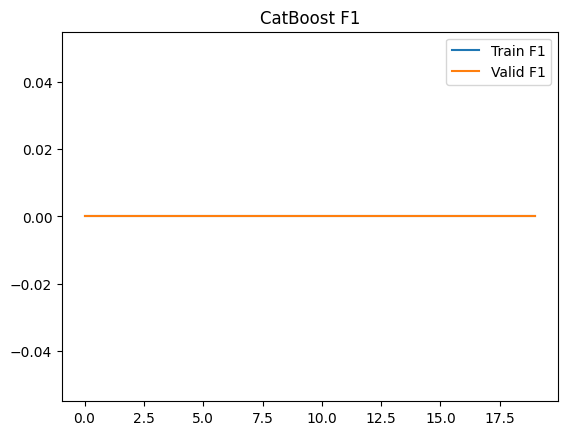

KeyError: 'AUC'

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

results = model.get_evals_result()

# iteration 길이
epochs = len(results['learn']['F1'])

x_axis = range(epochs)

plt.figure()
plt.plot(x_axis, results['learn']['F1'], label='Train F1')
plt.plot(x_axis, results['validation']['F1'], label='Valid F1')
plt.legend()
plt.title('CatBoost F1')
plt.show()

plt.figure()
plt.plot(x_axis, results['learn']['AUC'], label='Train AUC')
plt.plot(x_axis, results['validation']['AUC'], label='Valid AUC')
plt.legend()
plt.title('CatBoost AUC')
plt.show()


In [31]:
from sklearn.metrics import classification_report

oof_label = (oof_pred >= best_th).astype(int)

print(classification_report(y, oof_label))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       525
           1       0.30      1.00      0.46       223

    accuracy                           0.30       748
   macro avg       0.15      0.50      0.23       748
weighted avg       0.09      0.30      0.14       748



/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from sklearn.metrics import f1_score

oof_label = (oof_pred >= best_th).astype(int)

print("OOF F1:", f1_score(y, oof_label))



OOF F1: 0.4666666666666667


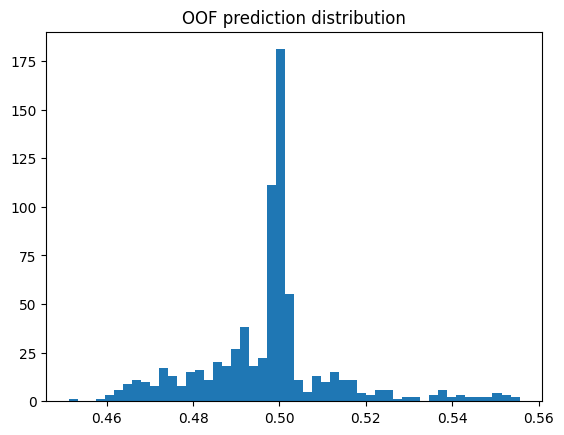

In [45]:
plt.hist(oof_pred,bins=50)
plt.title("OOF prediction distribution")
plt.show()


## 제출

In [46]:
from datetime import datetime

sub = pd.read_csv("OriginalData/sample_submission.csv")
sub["completed"] = pred_test

now = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"Submit/submit_cat{now}.csv"
print(filename)
sub.to_csv(filename, index=False)


Submit/submit_cat20260204_0033.csv


In [37]:
print(y.mean())


0.29812834224598933
